# Review Classification using Active Learning

**Author:** [Darshan Deshpande](https://twitter.com/getdarshan)<br>
**Date created:** 2021/10/29<br>
**Last modified:** 2021/10/29<br>
**Description:** Demonstrating the advantages of active learning through review classification.

## Introduction

With the growth of data-centric Machine Learning, Active Learning has grown in popularity
amongst businesses and researchers. Active Learning seeks to progressively
train ML models so that the resultant model requires lesser amount of training data to
achieve competitive scores.

The structure of an Active Learning pipeline involves a classifier and an oracle. The
oracle is an annotator that cleans, selects, labels the data, and feeds it to the model
when required. The oracle is a trained individual or a group of individuals that
ensure consistency in labeling of new data.

The process starts with annotating a small subset of the full dataset and training an
initial model. The best model checkpoint is saved and then tested on a balanced test
set. The test set must be carefully sampled because the full training process will be
dependent on it. Once we have the initial evaluation scores, the oracle is tasked with
labeling more samples; the number of data points to be sampled is usually determined by
the business requirements. After that, the newly sampled data is added to the training
set, and the training procedure repeats. This cycle continues until either an
acceptable score is reached or some other business metric is met.

This tutorial provides a basic demonstration of how Active Learning works by
demonstrating a ratio-based (least confidence) sampling strategy that results in lower
overall false positive and negative rates when compared to a model trained on the entire
dataset. This sampling falls under the domain of *uncertanity sampling*, in which new
datasets are sampled based on the uncertanity that the model outputs for the
corresponding label. In our example, we compare our model's false positive and false
negative rates and annotate the new data based on their ratio.

Some other sampling techniques include:

1. [Committee sampling](https://www.researchgate.net/publication/51909346_Committee-Based_Sample_Selection_for_Probabilistic_Classifiers):
Using multiple models to vote for the best data points to be sampled
2. [Entropy reduction](https://www.researchgate.net/publication/51909346_Committee-Based_Sample_Selection_for_Probabilistic_Classifiers):
Sampling according to an entropy threshold, selecting more of the samples that produce the highest entropy score.
3. [Minimum margin based sampling](https://arxiv.org/abs/1906.00025v1):
Selects data points closest to the decision boundary

## Importing required libraries

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

## Loading and preprocessing the data

We will be using the IMDB reviews dataset for our experiments. This dataset has 50,000
reviews in total, including training and testing splits. We will merge these splits and
sample our own, balanced training, validation and testing sets.

In [2]:
dataset = tfds.load(
    "imdb_reviews",
    split="train + test",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)
reviews, labels = tfds.as_numpy(dataset)

print("Total examples:", reviews.shape[0])

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Total examples: 50000


Active learning starts with labeling a subset of data.
For the ratio sampling technique that we will be using, we will need well-balanced training,
validation and testing splits.

In [3]:
val_split = 2500
test_split = 2500
train_split = 7500

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


### Fitting the `TextVectorization` layer

Since we are working with text data, we will need to encode the text strings as vectors which
would then be passed through an `Embedding` layer. To make this tokenization process
faster, we use the `map()` function with its parallelization functionality.

In [4]:

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


vectorizer = layers.TextVectorization(
    3000, standardize=custom_standardization, output_sequence_length=150
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)


def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label


train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

## Creating Helper Functions

In [5]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()


## Creating the Model

We create a small bidirectional LSTM model. When using Active Learning, you should make sure
that the model architecture is capable of overfitting to the initial data.
Overfitting gives a strong hint that the model will have enough capacity for
future, unseen data.

In [6]:

def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(150,)),
            layers.Embedding(input_dim=3000, output_dim=128),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(20, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model


## Training on the entire dataset

To show the effectiveness of Active Learning, we will first train the model on the entire
dataset containing 40,000 labeled samples. This model will be used for comparison later.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          384000    
                                                                 
 bidirectional (Bidirectiona  (None, 150, 64)          41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

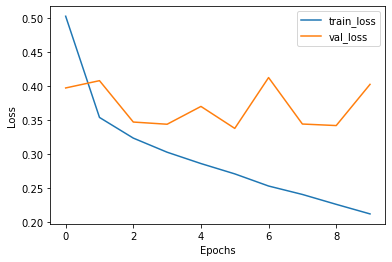

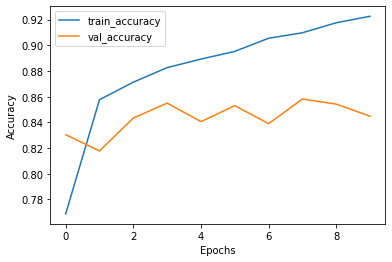

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.3471686840057373, 'binary_accuracy': 0.8471999764442444, 'false_negatives': 244.0, 'false_positives': 520.0}
----------------------------------------------------------------------------------------------------


In [7]:

def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset.batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=4, verbose=1),
            keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.h5", verbose=1, save_best_only=True
            ),
        ],
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = keras.models.load_model("FullModelCheckpoint.h5")

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model


# Sampling the full train dataset to train on
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

# Training the full model
full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)

## Training via Active Learning

The general process we follow when performing Active Learning is demonstrated below:

![Active Learning](https://i.imgur.com/dmNKusp.png)

The pipeline can be summarized in five parts:

1. Sample and annotate a small, balanced training dataset
2. Train the model on this small subset
3. Evaluate the model on a balanced testing set
4. If the model satisfies the business criteria, deploy it in a real time setting
5. If it doesn't pass the criteria, sample a few more samples according to the ratio of
false positives and negatives, add them to the training set and repeat from step 2 till
the model passes the tests or till all available data is exhausted.

For the code below, we will perform sampling using the following formula:<br/>

![Ratio Sampling](https://i.imgur.com/LyZEiZL.png)

Active Learning techniques use callbacks extensively for progress tracking. We will be
using model checkpointing and early stopping for this example. The `patience` parameter
for Early Stopping can help minimize overfitting and the time required. We have set it
`patience=4` for now but since the model is robust, we can increase the patience level if
desired.

Note: We are not loading the checkpoint after the first training iteration. In my
experience working on Active Learning techniques, this helps the model probe the
newly formed loss landscape. Even if the model fails to improve in the second iteration,
we will still gain insight about the possible future false positive and negative rates.
This will help us sample a better set in the next iteration where the model will have a
greater chance to improve.

In [ ]:

def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=5000,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "AL_Model.h5", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Generating labels from the output probabilities
        rounded = tf.where(tf.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )
        history = model.fit(
            train_dataset.cache().shuffle(20000).batch(256),
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=4, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model("AL_Model.h5")

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model


active_learning_model = train_active_learning_models(
    train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          384000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 64)          41216     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

## Conclusion

Active Learning is a growing area of research. This example demonstrates the cost-efficiency
benefits of using Active Learning, as it eliminates the need to annotate large amounts of
data, saving resources.

The following are some noteworthy observations from this example:

1. We only require 30,000 samples to reach the same (if not better) scores as the model
trained on the full datatset. This means that in a real life setting, we save the effort
required for annotating 10,000 images!
2. The number of false negatives and false positives are well balanced at the end of the
training as compared to the skewed ratio obtained from the full training. This makes the
model slightly more useful in real life scenarios where both the labels hold equal
importance.

For further reading about the types of sampling ratios, training techniques or available
open source libraries/implementations, you can refer to the resources below:

1. [Active Learning Literature Survey](http://burrsettles.com/pub/settles.activelearning.pdf) (Burr Settles, 2010).
2. [modAL](https://github.com/modAL-python/modAL): A Modular Active Learning framework.
3. Google's unofficial [Active Learning playground](https://github.com/google/active-learning).